# Gradient Descent

In this notebook we will implement 2 variants of gradient descent and use it to find the linear coefficients that minimize the mean square error of a linear regression task.

## 0. Imports and Data

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

First, we import our data from the Rice Bikes transaction dataset. We will attempt to predict turnaround time as a linear function of inpatient bike repair queue length.

In [2]:
df = pd.read_csv("../../data/rb_tx_data.csv")
df = df.set_index("TransactionID")

# we apply some basic filters to get transactions of interest
df = df.loc[(df['TotalCost']>0) &
            (df['TurnaroundTime']>0) &
            (df['TurnaroundTime']<38) &  # less than two weeks
            (df['TransactionType']== 'inpatient') & # designated as inpatient
            (df['DayCreated']!=df['DayCompleted'])  # actually inpatient
            ]

X = df['QueueBikes']
y = df['TurnaroundTime']


## 1. Gradient Descent Implementation

In [3]:
def grad_descent(f, grad_f, w_0, eta, epochs=10):
    """
    A generic implementation of gradient descent.
    Supports multidimensional functions.
    Note that the number of function arguments must match the 
        number of gradient arguments as well as the number of
        initial paramters.

    Parameters:
        - f:      function to minimize.
        - grad_f: the gradient of f. Must return a np array
        - w_0:    the initial paramters for f. Must be an np array
        - eta:    the update rate
        - epochs: the number of times to update paramters 

    Returns:
        - F: a list containing the function value at the parameters of each epoch
        - W: a list containing the parameter vales of each epoch
    """

    # store function values at each step
    F = []
    # store function parameters at each step
    W = []

    # initialize function paramters
    w =w_0

    for _ in range(epochs):
        # update current paramters
        w-= eta * grad_f(*w)

        # record function and new paramters
        F.append(f(*w))
        W.append(w.copy())

    return F, W


Next, we implment the mean squared error between our predicted and actual values as a function of the estimated linear coefficients. Note that the data (X,y) is treated as a constant with respect to the cost function and the gradient

In [4]:
def f(m,b):
    """
    Mean squared error as a function of our linear coefficients.
    """
    return mean_squared_error(y, m*X+b)

In [5]:
def grad_f(m,b):
    """
    The gradient of mean squared error as a function of our linear coefficients,
    """

    # one error per sample
    errors = y-(m*X+b)

    n=len(X)

    # elements of the gradient
    df_dm = (-2/n)*errors@X
    df_db = (-2/n)*errors.sum()

    return np.array([df_dm, df_db ])

In [6]:
F, W = grad_descent(f, 
                    grad_f, 
                    w_0 = np.array([0.0, 0]), 
                    eta=0.001, 
                    epochs = 1000)


In [7]:
m_star, b_star = W[-1]
print(f"The resulting regression line is given by {m_star:.3g}x+{b_star:.3g} ")

The resulting regression line is given by 0.531x+4.35 


Each additional bike in the repair queue increases the expected turnaround time by approximately 0.5 shifts, and the expected turnaround time when the repair queue is empty is 4.35 shifts. As a business owner and absolute bike nerd this is really cool!!

Let's view the the resulting regression line atop our transaction original data:

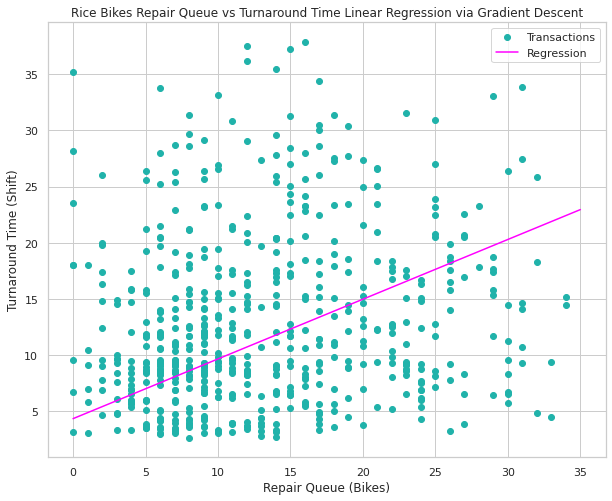

In [8]:
sns.set(style="whitegrid")
fig = plt.figure(figsize = (10,8))

domain = np.linspace(0,35, 1000)

plt.scatter(X,y, color="lightseagreen", label="Transactions")
plt.plot(domain, domain*m_star + b_star, color="magenta", label="Regression")
plt.title("Rice Bikes Repair Queue vs Turnaround Time Linear Regression via Gradient Descent")
plt.ylabel("Turnaround Time (Shift)")
plt.xlabel("Repair Queue (Bikes)")
plt.legend(loc="upper right")


While there is a lot of noise present, and the number of transactions at long repair queue lengths is quite sparse, we can see the relationship suggested by the regression line tracks with the general trend of a positive correlation between these two variables.

Since the mean squared error of simpole linear regression is a 2D function of the linear coefficients, let us see how the gradient descent algorithm progresses down the surface of the cost function.

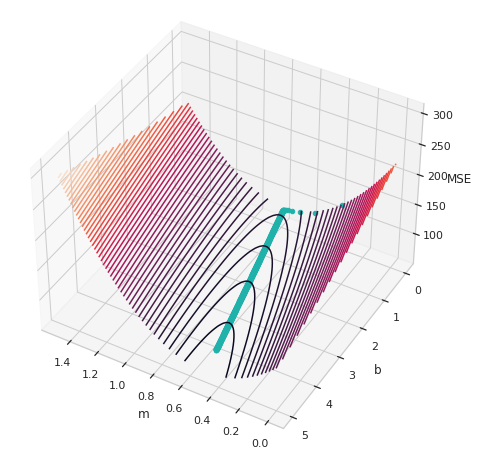

In [9]:
mesh = np.meshgrid(np.linspace(0,1.5,100), np.linspace(0,5,100))
domain_X, domain_Y = mesh

Z = []

for d_x, d_y in zip(domain_X.flatten(), domain_Y.flatten()):
    Z.append(f(d_x,d_y))

Z= np.array(Z).reshape((len(domain_X),len(domain_Y)))

fig = plt.figure(figsize = (10,8))

ax = plt.axes(projection='3d')

ax.contour3D(domain_X, domain_Y, Z, 50)

for i in range(len(W)):
    ax.scatter3D([W[i][0]], 
                 [W[i][1]], 
                 [f(W[i][0], W[i][1])], color = "lightseagreen")

ax.set_xlabel('m')
ax.set_ylabel('b')
ax.set_zlabel('MSE')

ax.view_init(40, 120)

Due to the valley-like geometry of the cost surface, the initial direction of steepest descent from $(b_0,b_1)=(0,0)$ comes from increasing the SLR slope $b_1$. Once the slope reaches the bottom of the valley at approximately $b_0=0.5$, the direction of steepest descent switches to increases in the SLR intercept $b_1$.

Finally, let us check the resulting trajectory of the cost function along this path.

Text(0, 0.5, 'MSE')

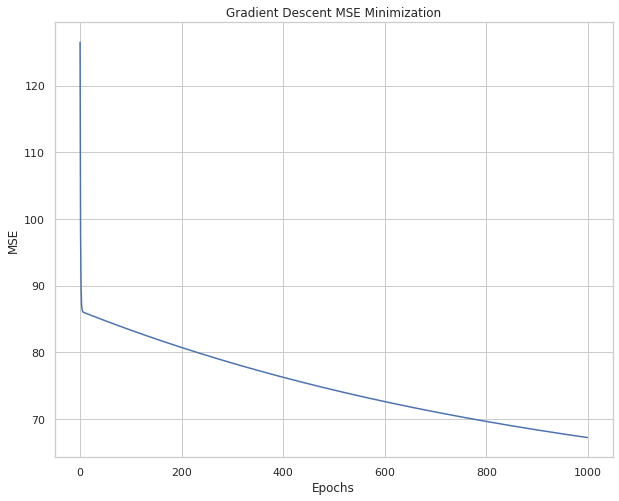

In [10]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))
plt.plot(range(len(F)), F)
plt.title("Gradient Descent MSE Minimization")
plt.xlabel("Epochs")
plt.ylabel("MSE")

## 2. Batch Gradient Descent

By modifying the gradient function to use only a random subset of samples, we can obtain an implementation of batch gradient descent.

In [11]:
def grad_f_batch(m,b, k):
    """
    A batched approximation of the gradient of MSE as a function 
    of our linear coefficients and a sample batch size.
    """

    # select k random samples
    idx = np.random.randint(0, len(X), k)
    X_batch = np.take(X, idx)
    y_batch = np.take(y, idx)

    # one error per sample
    errors = y_batch-(m*X_batch+b)

    n=len(X)

    # elements of the gradient
    df_dm = (-2/n)*errors@X_batch
    df_db = (-2/n)*errors.sum()

    return np.array([df_dm, df_db ])

In [12]:
k=10
F,W = grad_descent(f, 
                   lambda m,b: grad_f_batch(m,b,k), 
                   w_0= np.array([0.0, 0.0]),
                   eta=0.01, 
                   epochs=5000)

Text(0, 0.5, 'MSE')

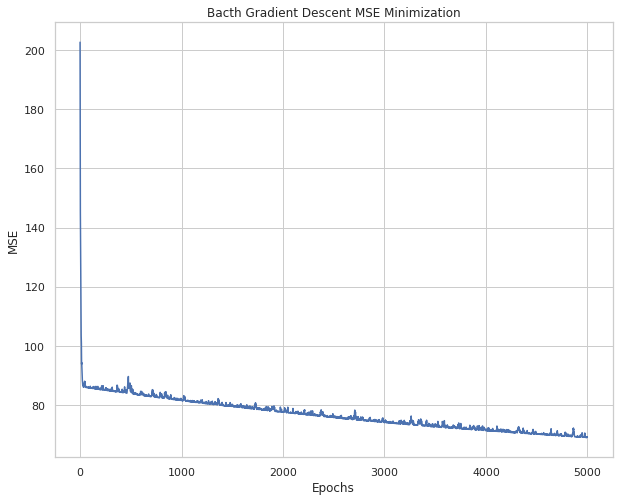

In [13]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,8))
plt.plot(range(len(F)), F)
plt.title("Bacth Gradient Descent MSE Minimization")
plt.xlabel("Epochs")
plt.ylabel("MSE")

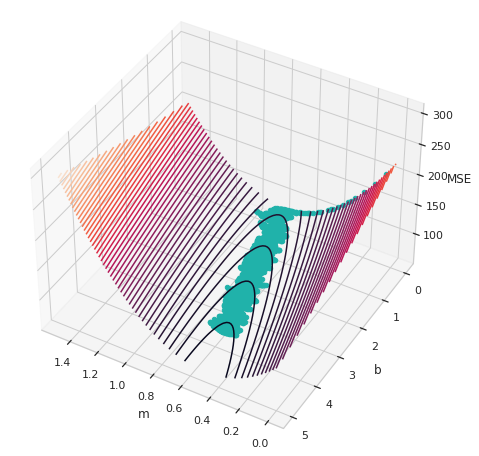

In [14]:
mesh = np.meshgrid(np.linspace(0,1.5,100), np.linspace(0,5,100))
domain_X, domain_Y = mesh

Z = []

for d_x, d_y in zip(domain_X.flatten(), domain_Y.flatten()):
    Z.append(f(d_x,d_y))

Z= np.array(Z).reshape((len(domain_X),len(domain_Y)))

fig = plt.figure(figsize = (10,8))

ax = plt.axes(projection='3d')

ax.contour3D(domain_X, domain_Y, Z, 50)

for i in range(len(W)):
    ax.scatter3D([W[i][0]], 
                 [W[i][1]], 
                 [f(W[i][0], W[i][1])], color = "lightseagreen")

ax.set_xlabel('m')
ax.set_ylabel('b')
ax.set_zlabel('MSE')

ax.view_init(40, 120)

As we can see, batch gradient descent still approaches a local minimum of the cost surface but under a less stable path